In [3]:
import torch
import torch.nn as nn
from torch.optim import SGD
import matplotlib.pyplot as plt
from numpy import *
import math
from tqdm import tqdm
plt.style.use(['science','notebook','grid'])
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

In [4]:
valsref = load(r"C:\Users\Nunocastanheira\Desktop\boooks\research\Gelb!\Code\test\Mat\Master_mat.npy") #Load npy for reference spectra.
valsy = load(r"C:\Users\Nunocastanheira\Desktop\boooks\research\Gelb!\Code\test\Mat\12 9\MastertestScat.npy") #Load npy for scattering-removed spectra.

with open(r"C:\Users\Nunocastanheira\Desktop\boooks\research\Gelb!\Code\test\Mat\12 9\Master_listScat.txt",'r') as myfile: #Print txt file.
    data=myfile.read()
    print([i.strip().split() for i in data.split(' \\n') if len(i.strip())>0])

[['Si', 'SiO2', 'Al', 'GaAs', 'Ge', 'In4Sn3O12', 'Cu', 'ZnO', 'LiNbO3', 'KTiOPO4', 'SiC', 'SiO2C', 'AlC', 'GaAsC', 'GeC', 'In4Sn3O12C', 'CuC', 'ZnOC', 'LiNbO3C', 'KTiOPO4C', 'Thickness', 'Range', '=', '10-10nm', 'Array', 'dimensions', '=', '(20,', '1,', '2048,', '2)']]


In [5]:
with open(r"C:\Users\Nunocastanheira\Desktop\boooks\research\Gelb!\Code\test\Mat\12 9\Master_listScat.txt",'r') as myfile: #Use txt list for each material. Will help when producing plots.
    data=myfile.read()
    data = [i.strip().split() for i in data.split(' \\n') if len(i.strip())>0]

In [6]:
for i in range(20): #Change range to number of materials.
    print(data[0][i])


Si
SiO2
Al
GaAs
Ge
In4Sn3O12
Cu
ZnO
LiNbO3
KTiOPO4
SiC
SiO2C
AlC
GaAsC
GeC
In4Sn3O12C
CuC
ZnOC
LiNbO3C
KTiOPO4C


In [7]:
data = data[0][:20]

In [33]:
energy = torch.tensor(valsref[0,0,:,0],dtype=torch.float) #Energies. This is the same array for all spectra, so use any spectra's x-axis.
valNtrain = valsref[:,0,:,1]*10**7 #All y-axes for reference spectra. You can normalize this, but here I just multiplied by 10^7
valNy= valsy[:,0,:,1]*10**7 #All y-axes for back-scattering removed spectra. You can normalize this, but here I just multiplied by 10^7

# for i in range(shape(valNtrain)[0]): Normalization loop.
#     t = valNtrain[i] 
#     t1 = valNy[i] 
#     norm = trapz(t)
#     norm1 = trapz(t1)
#     valNtrain[i] = t/norm*1000
#     valNy[i] = t1/norm1*1000

train = (torch.tensor(valNtrain,dtype=torch.float))
y = (torch.tensor(valNy,dtype=torch.float))

print(shape(train))
print(shape(y))
print(trapz(y[0]))

torch.Size([20, 2048])
torch.Size([20, 2048])
1115.4365


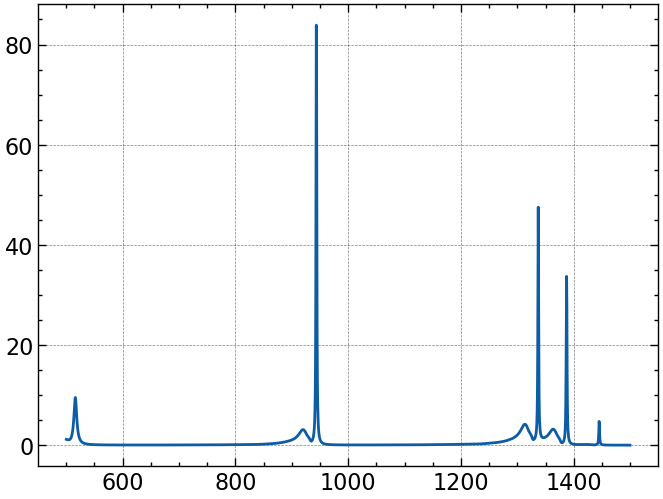

In [34]:
plt.plot(energy,y[11])

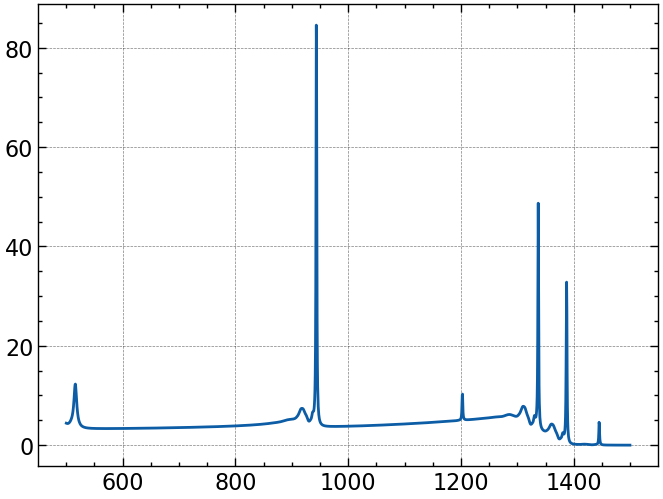

In [35]:
plt.plot(energy,train[11])

In [36]:
def train_model(x,y,f, n_epochs=500): #Model training. Consult PyTorch docs for inputs/out.
    opt = SGD(f.parameters(), lr=10**-2) #Perform stochastic gradient descent.
    L = nn.MSELoss() #New mean-squared error loss after SGD.

    # Train model.
    losses = []
    for _ in tqdm(range(n_epochs)):
        opt.zero_grad() 
        loss_value = L(f(x), y)
        loss_value.backward() 
        opt.step() 
        losses.append(loss_value.item())
    return f, losses #Output is the trained function and the loss for each step. 

N = 2**7 #Array size. Arbitrary, but powers of 2 tend to be (negligibly) faster for most code. 
class MyNeuralNet(nn.Module): #Neural net in question.
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(2048,N) #Input x is [N,2048]. Linear layers are fed to nonlinear activation layers.
        self.Matrix2 = nn.Linear(N,N) #Linear layer fed to activation layer below.
        self.Matrix3 = nn.Linear(N,N)
        self.Matrix4 = nn.Linear(N,N)
        self.Matrix5 = nn.Linear(N,2048) #Output is [N,2048]. N arrays are back-scattering removed spectra.
        #Nonlinear activations.
        self.R = nn.ReLU()
        self.E = nn.Tanh()
        self.P = nn.Mish()
        self.T = nn.GELU()
    def forward(self,x):
        x = self.R(self.Matrix1(x))
        x = self.P(self.Matrix2(x))
        x = self.E(self.Matrix3(x))
        x = self.T(self.Matrix4(x))
        x = self.Matrix5(x)
        return x.squeeze()

x = train
f = MyNeuralNet()
n_epochs=100000
# Train model
f, losses = train_model(x,y,f, n_epochs)

100%|██████████| 100000/100000 [18:12<00:00, 91.56it/s]


In [37]:
print(min(losses))
shape(losses)

4.0022695202424075e-07


(100000,)

In [38]:
shape(f(x))

torch.Size([20, 2048])

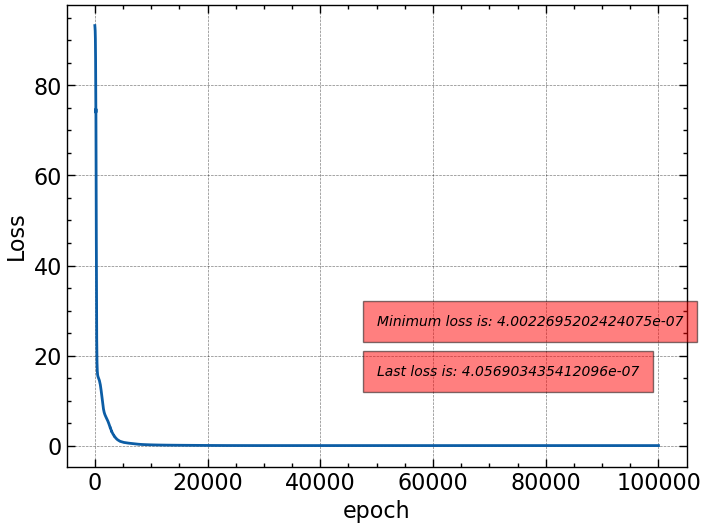

In [39]:
import os
import shutil

path = '1 coll' 

#Plot losses, and optionally save.
plt.plot(losses)
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.text(0.5*n_epochs, max(losses)/6, 'Last loss is: {}'.format(losses[-1]), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
plt.text(0.5*n_epochs, max(losses)/3.5, 'Minimum loss is: {}'.format(min(losses)), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
plt.savefig('{}\losses'.format(path), bbox_inches='tight')

plt.show()

In [40]:
torch.save(f, '{}\Material Character 1 coll.pt'.format(path)) #Save model.

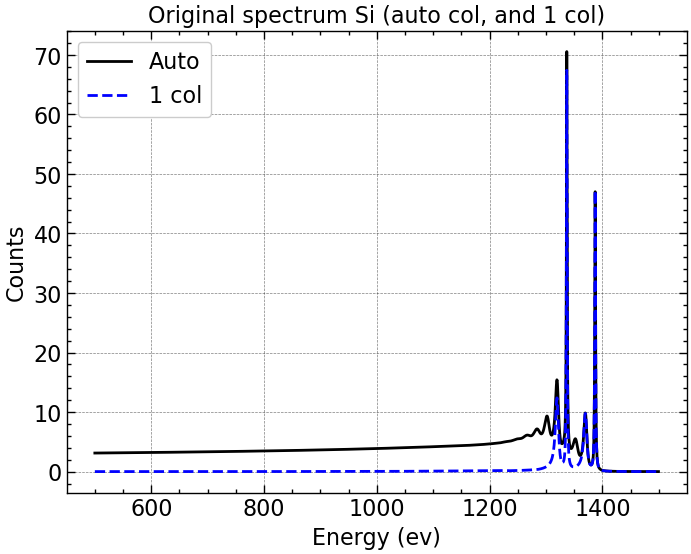

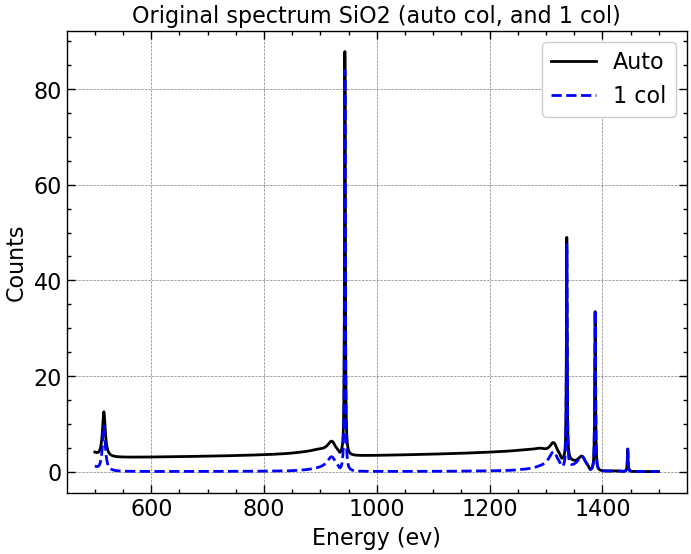

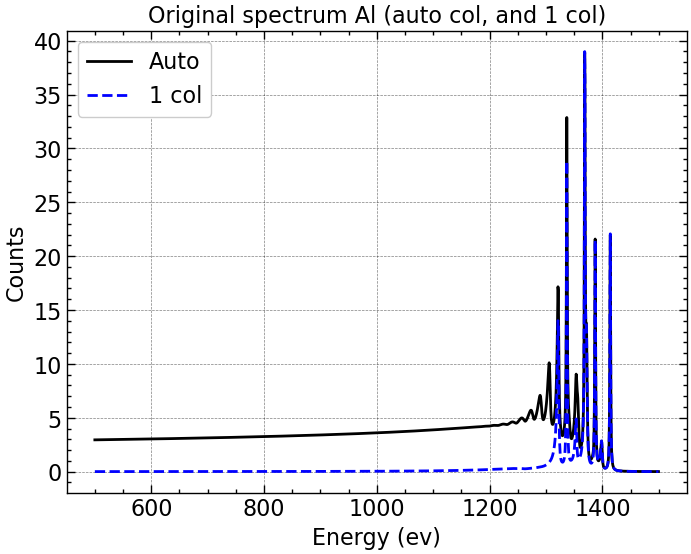

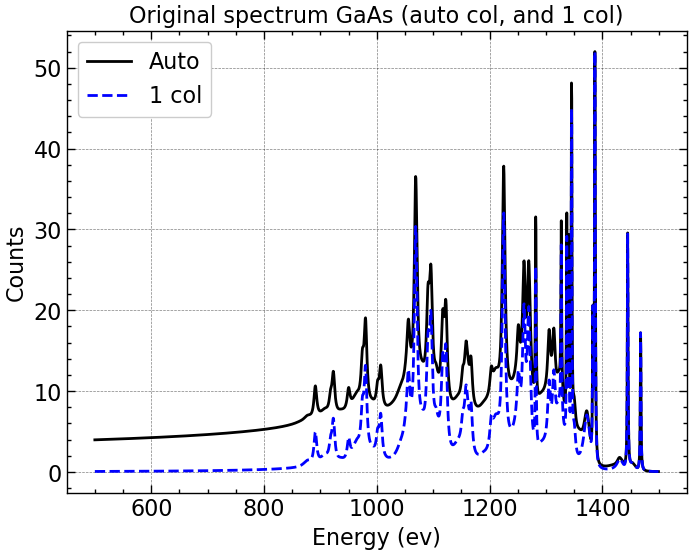

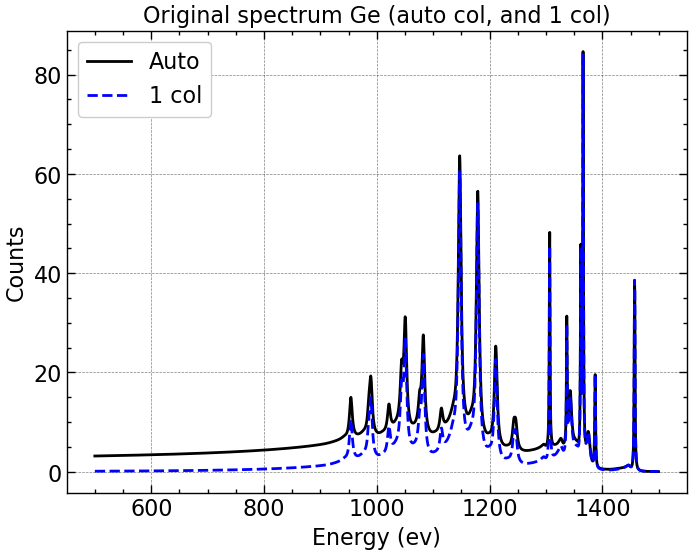

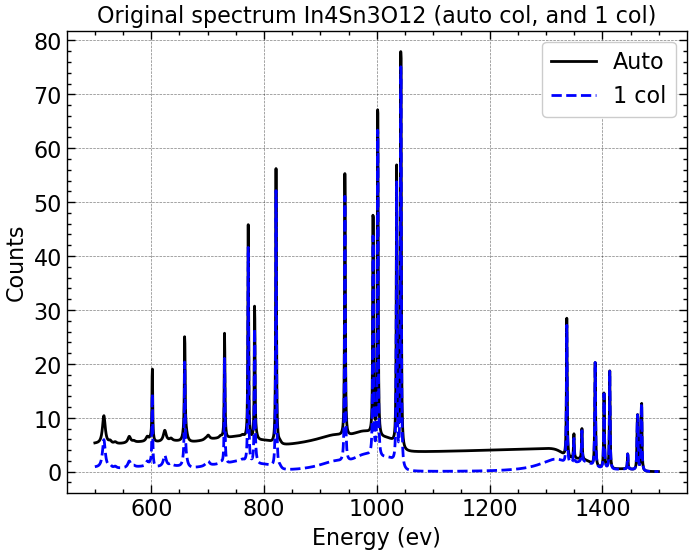

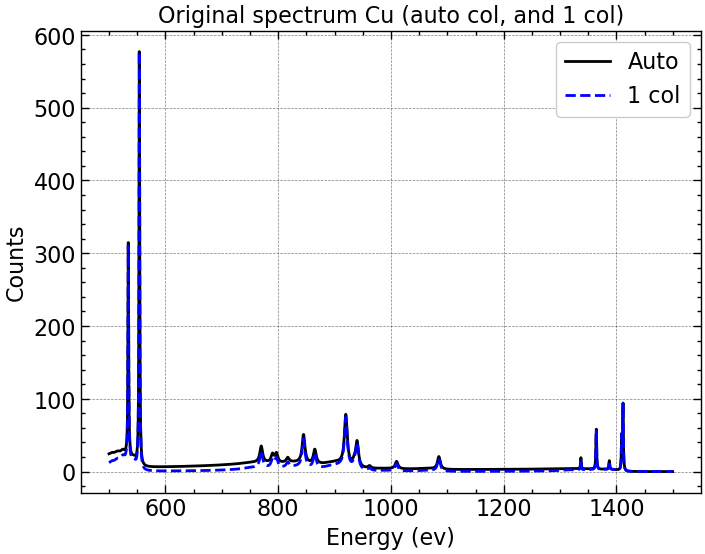

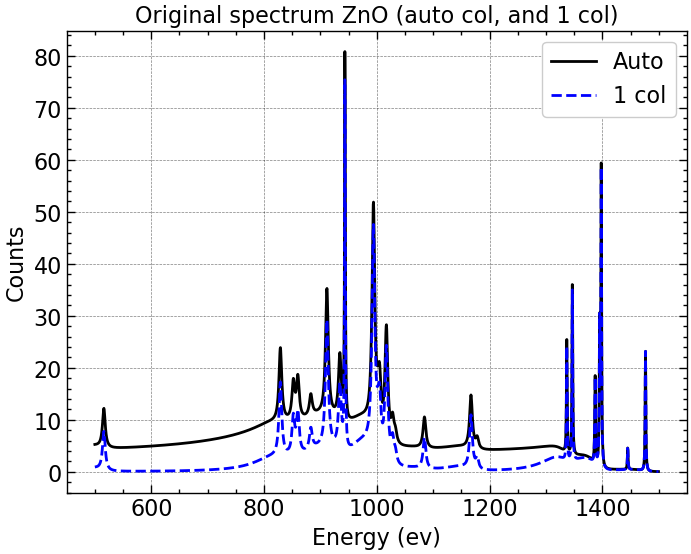

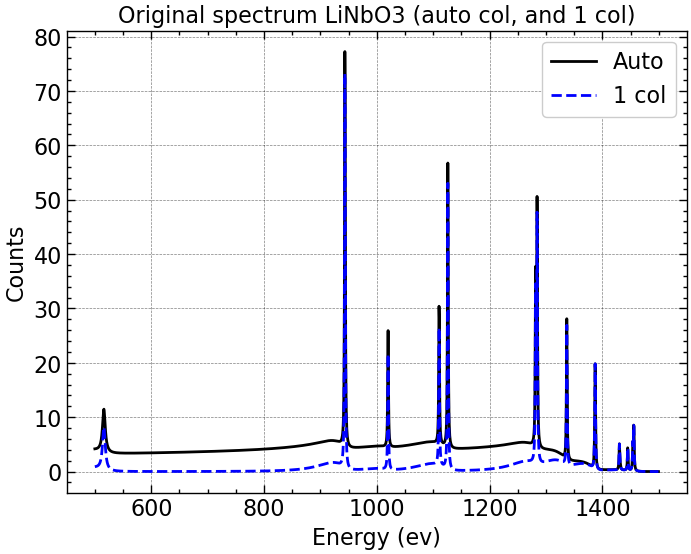

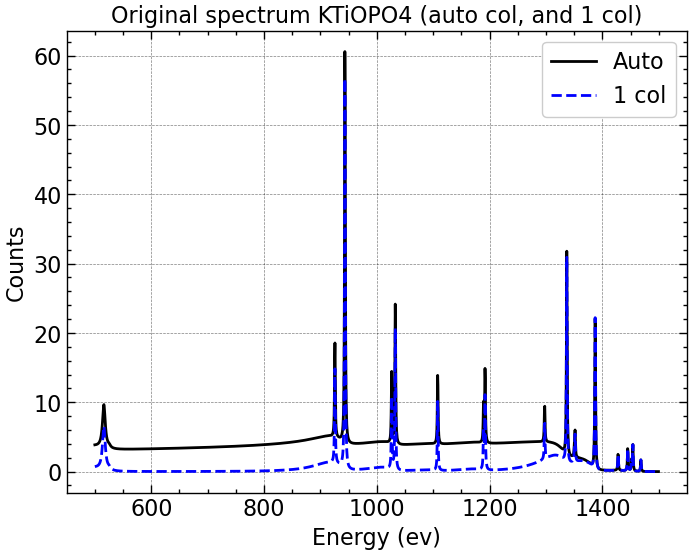

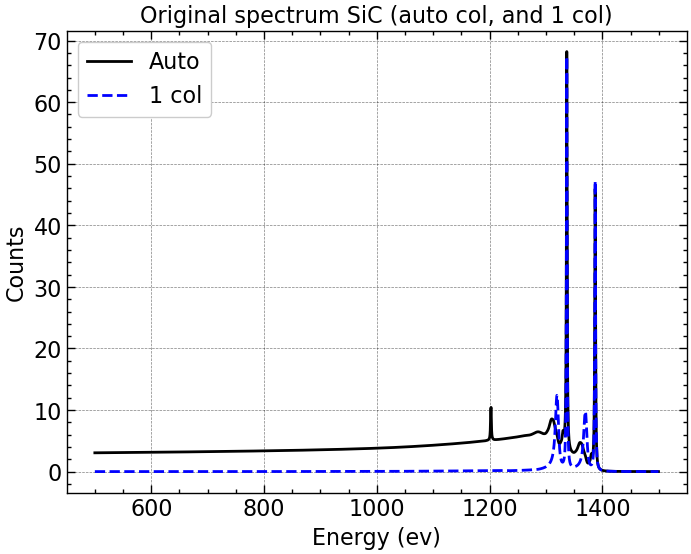

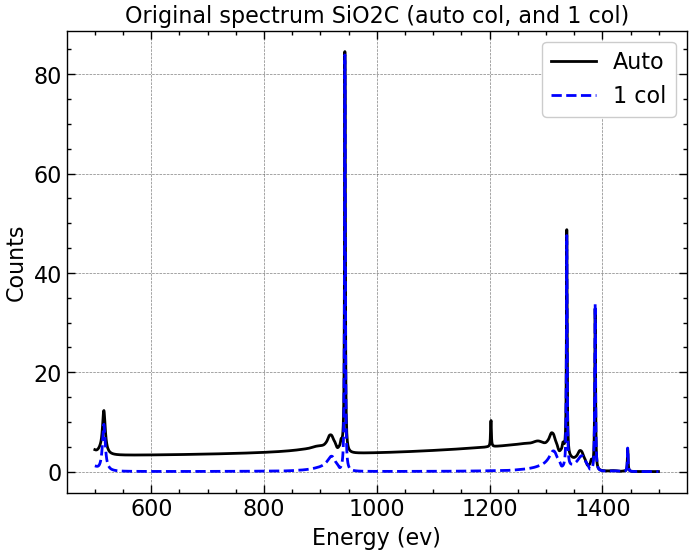

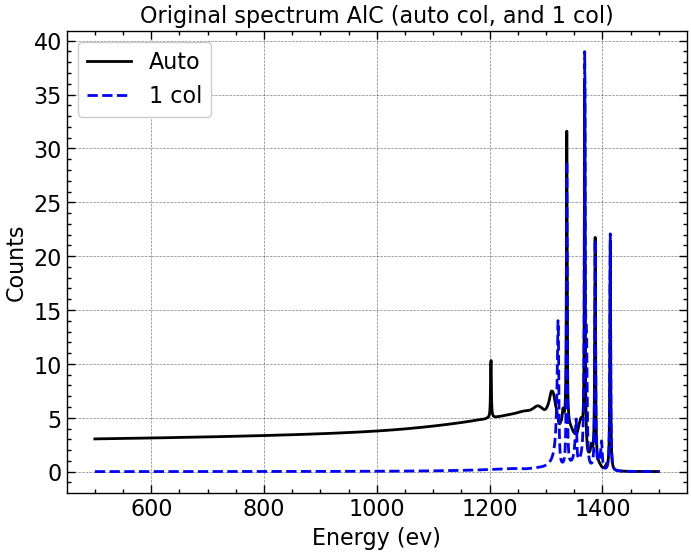

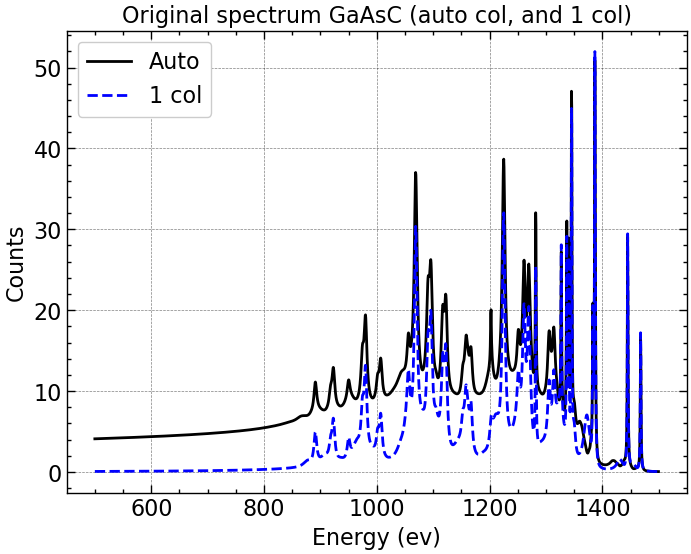

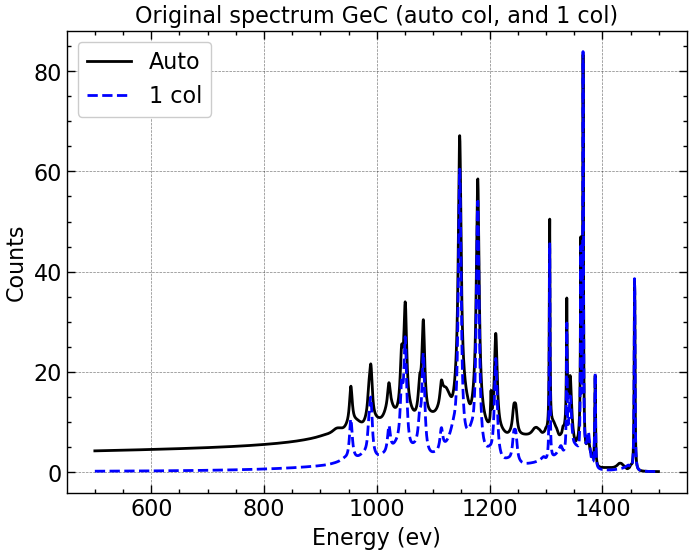

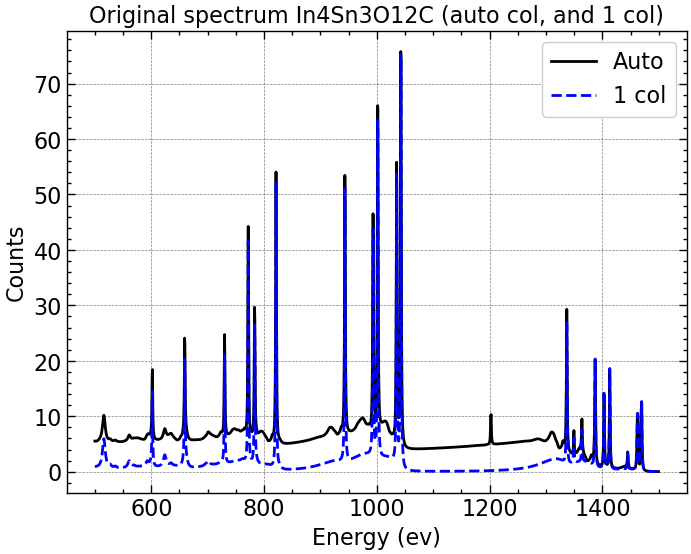

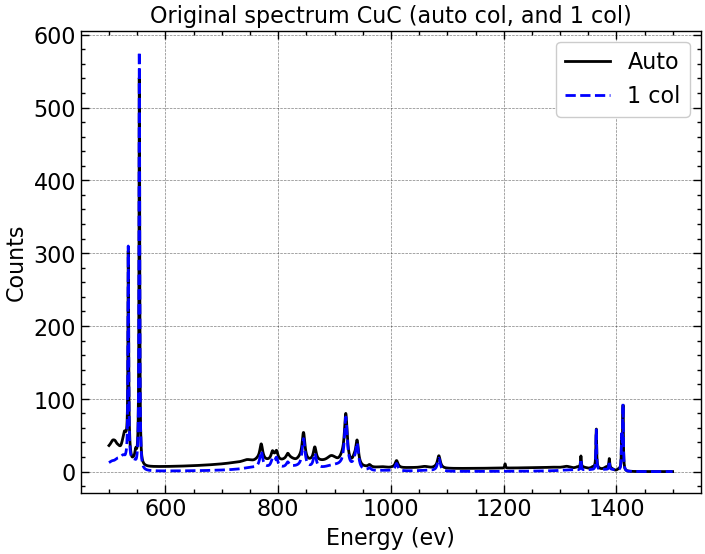

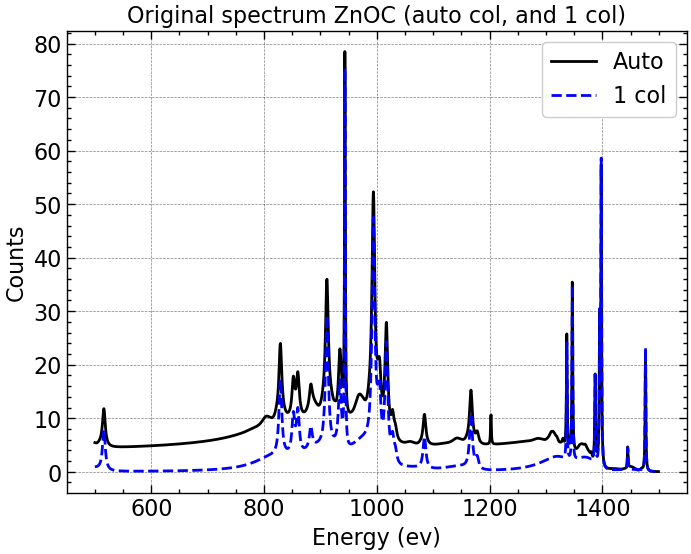

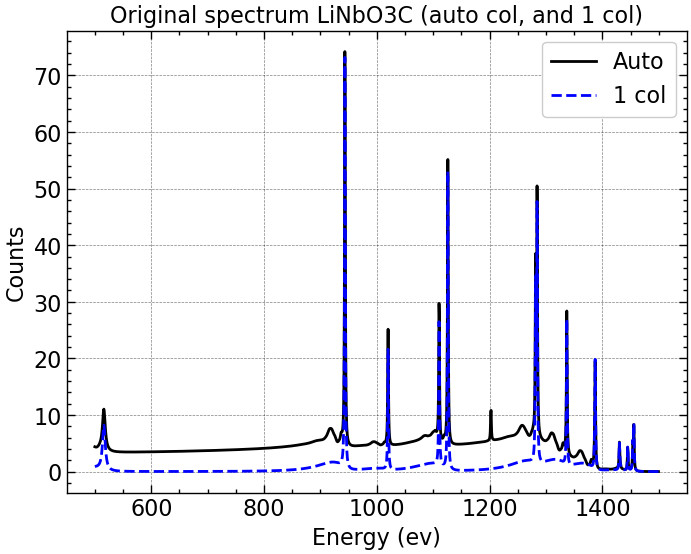

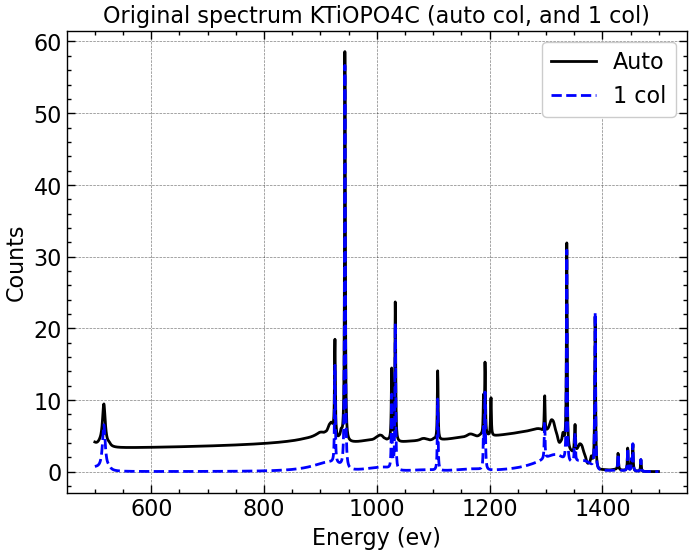

In [43]:
for i in range(20): #Plot reference spectra, along with the exact back-scattering removal.
    plt.plot(energy,train.detach().numpy()[i], 'k',alpha = 1)
    plt.plot(energy,y.detach().numpy()[i], 'b--', alpha = 1)
    plt.xlabel("Energy (ev)")
    plt.ylabel("Counts")
    plt.title("Original spectrum {} (auto col, and 1 col)".format(data[i]))
    plt.legend(["Auto", "1 col"])

    plt.savefig('{}\original {}'.format(path,data[i]), bbox_inches='tight')
    plt.show()
    plt.close()

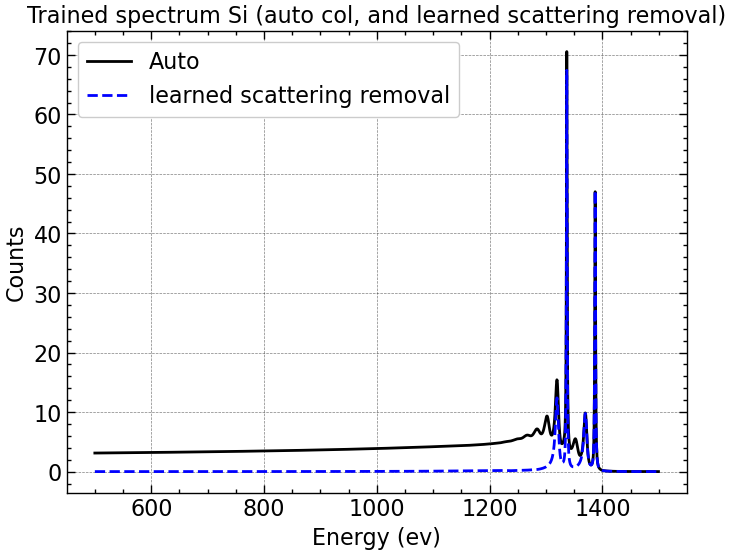

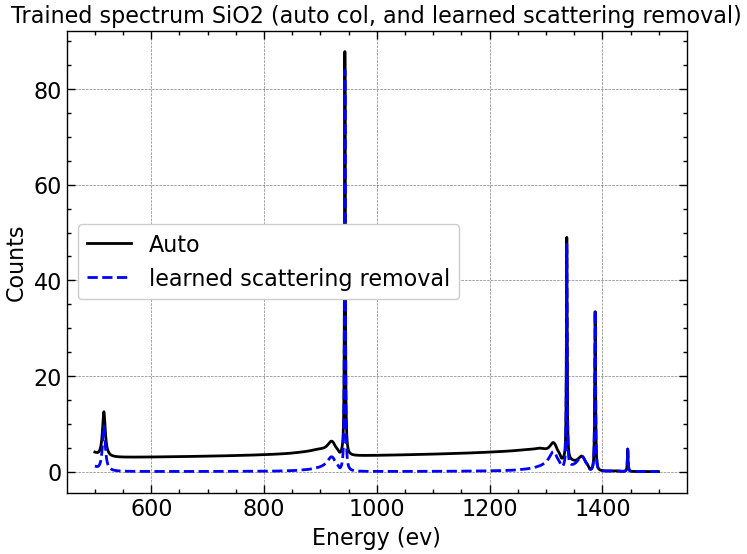

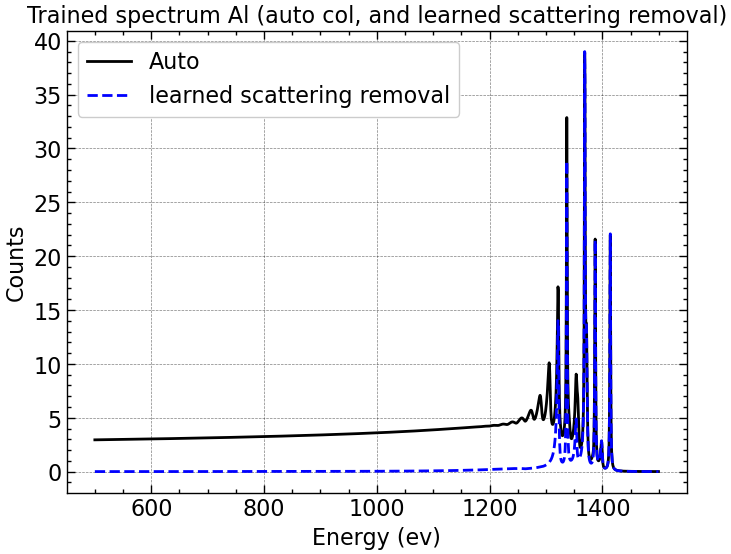

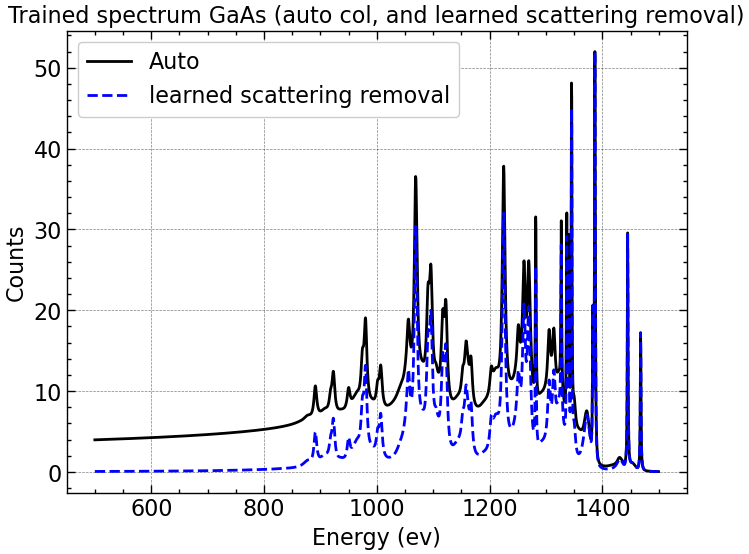

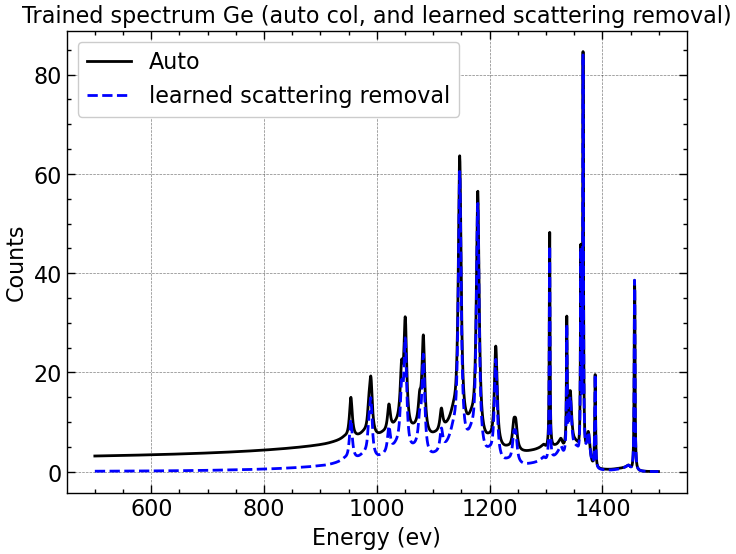

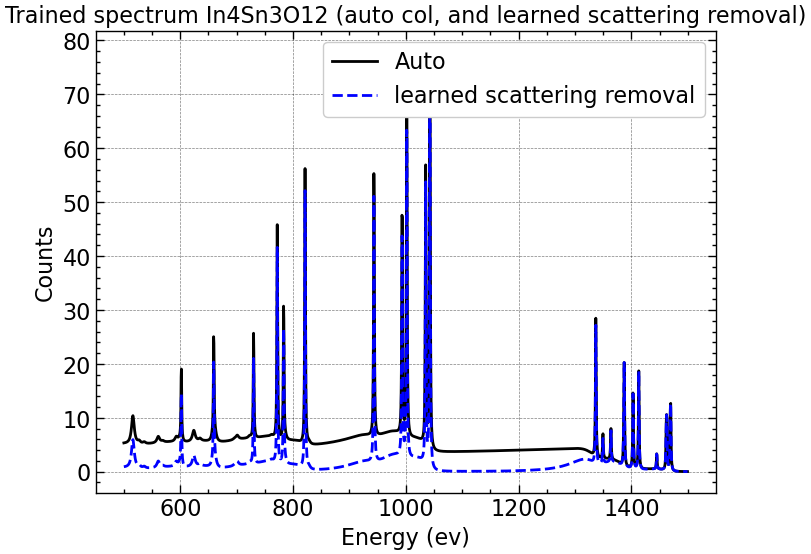

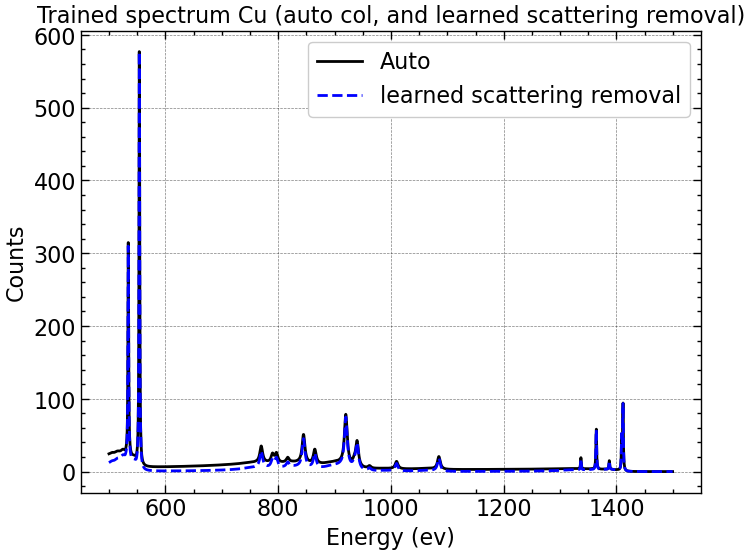

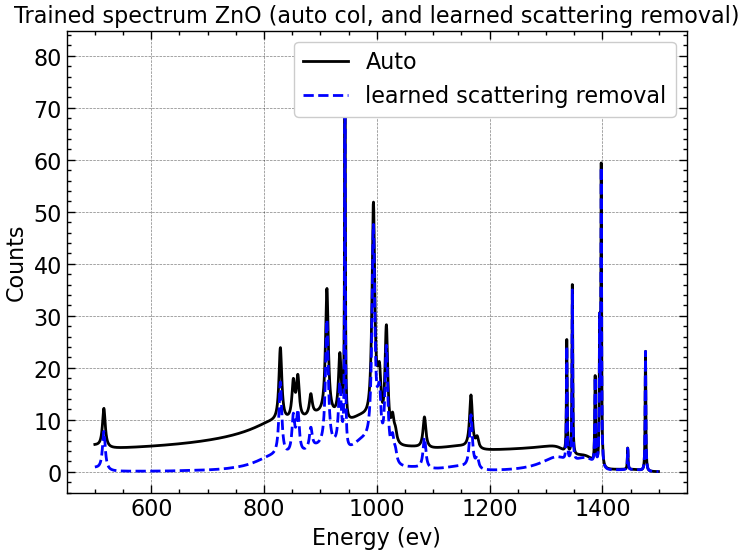

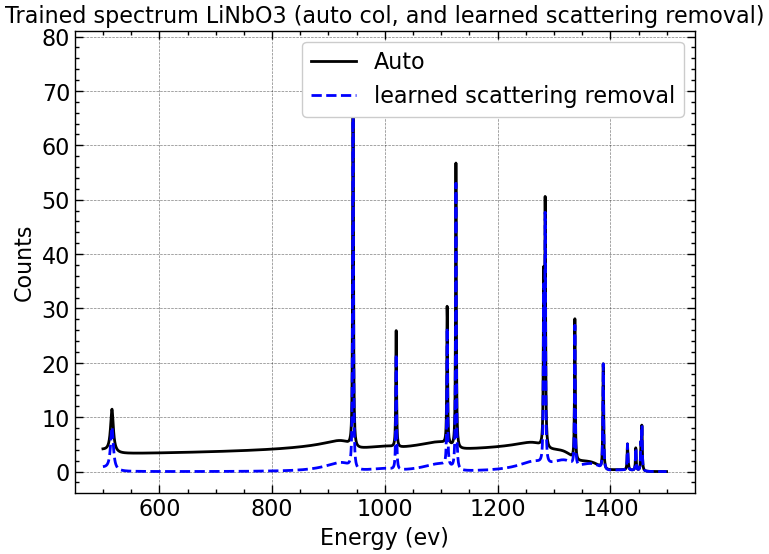

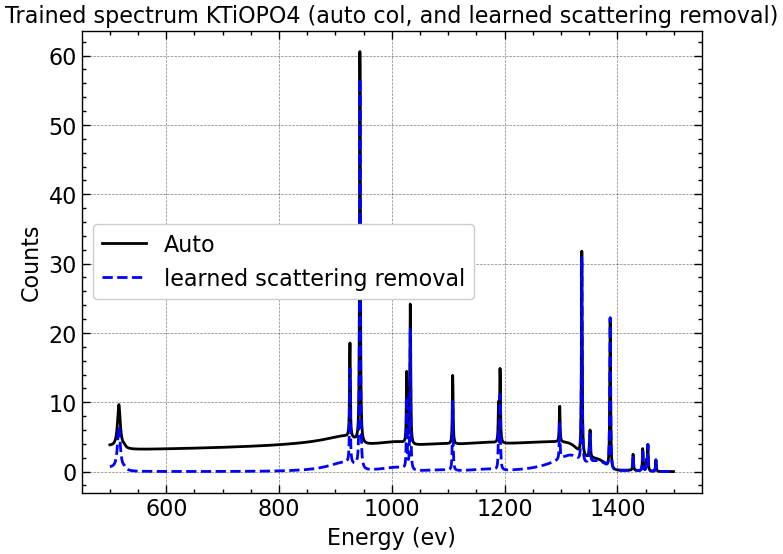

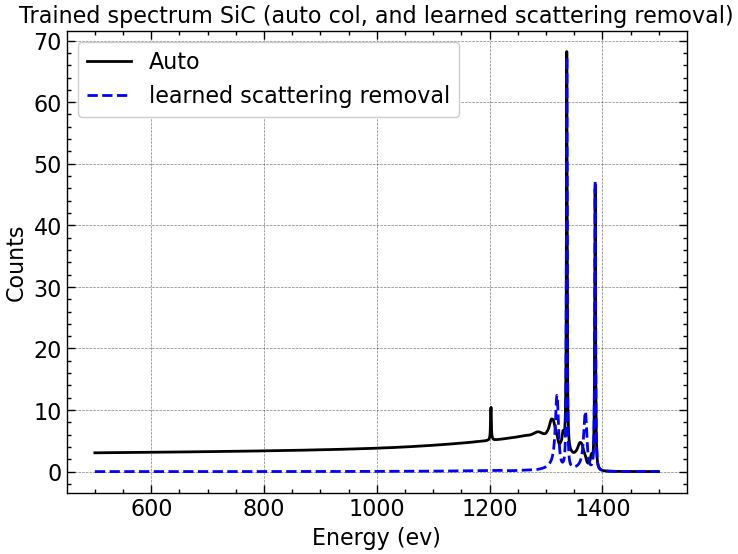

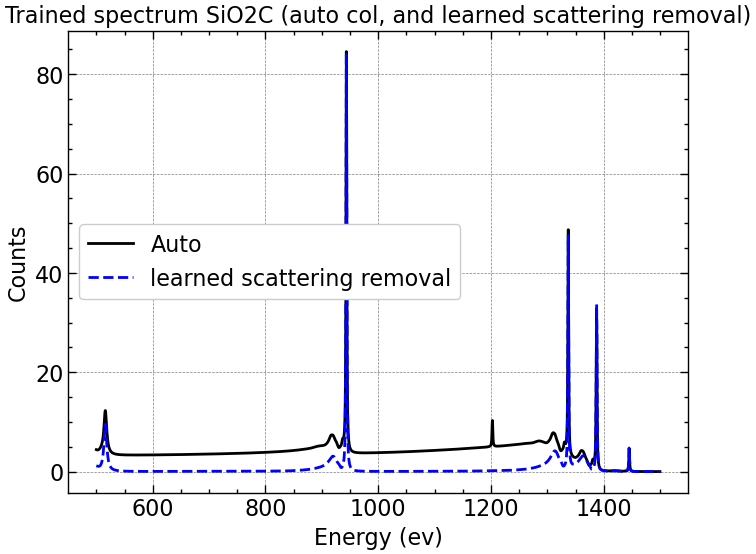

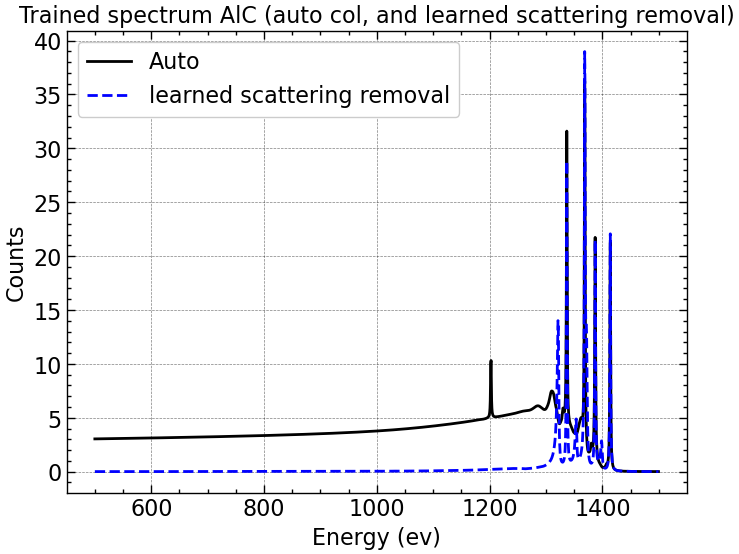

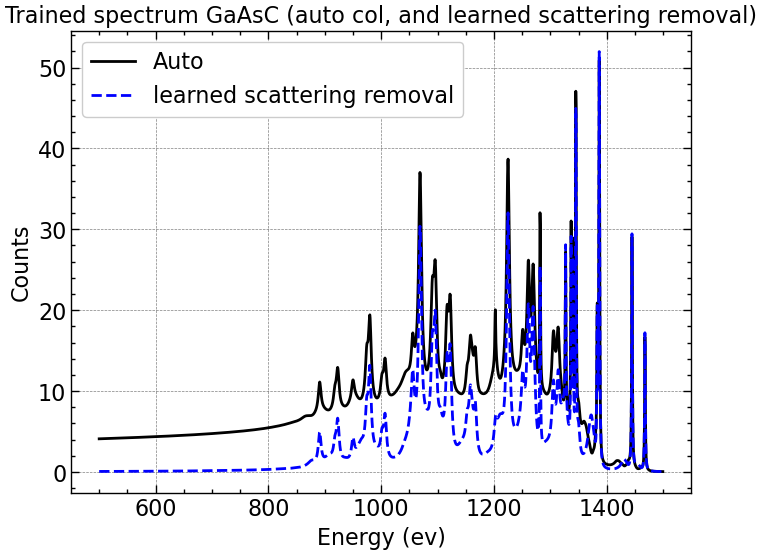

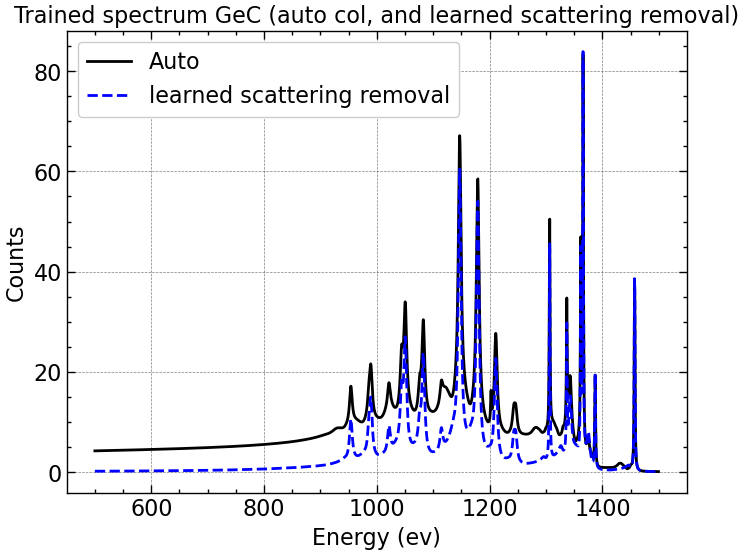

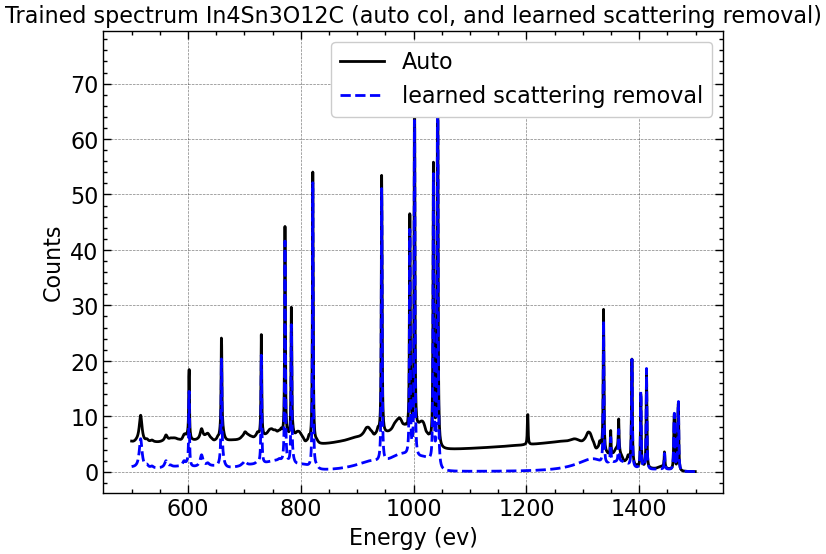

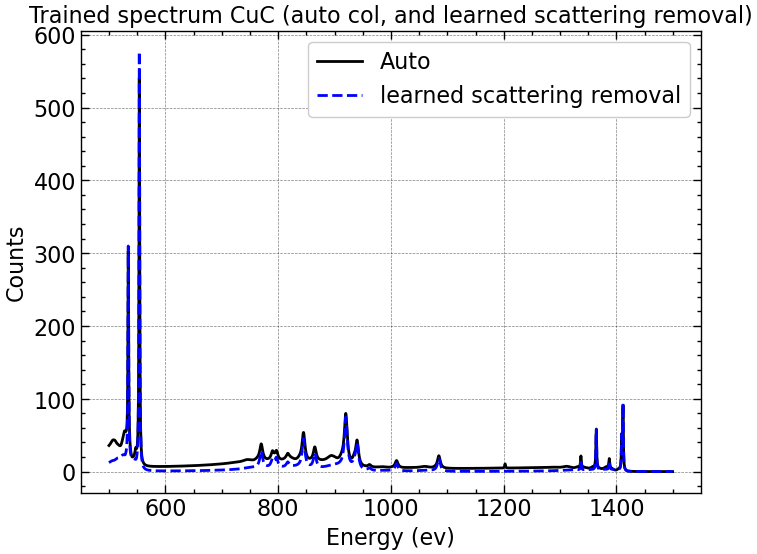

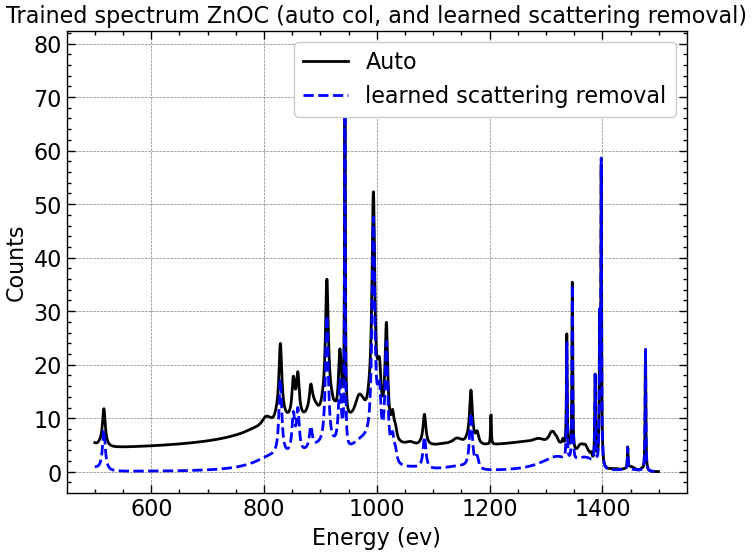

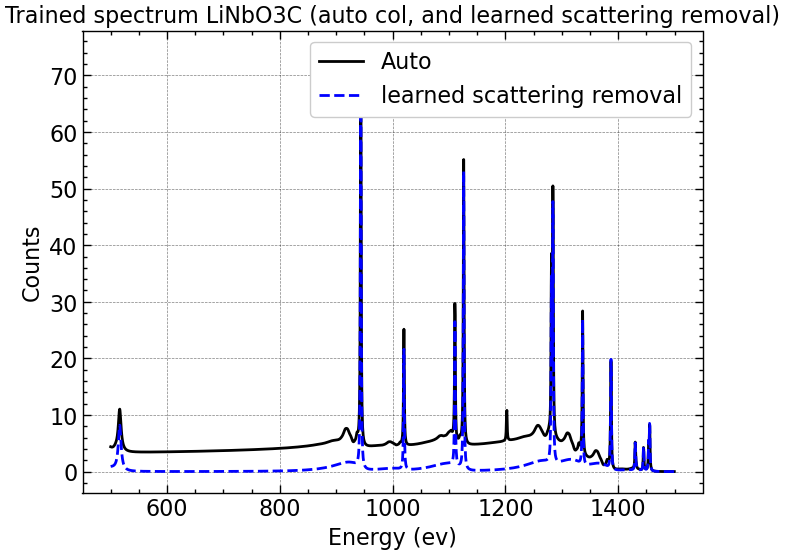

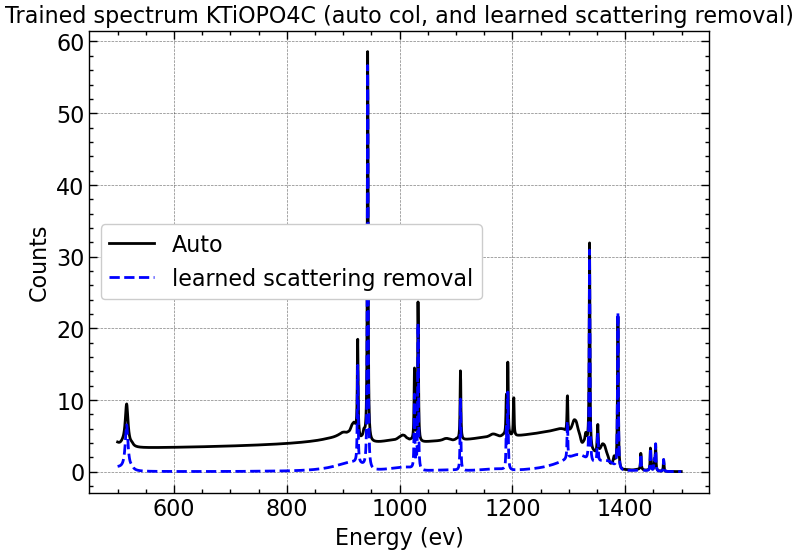

In [44]:
for i in range(20): #Plot reference spectra, along with the TRAINED back-scattering removal from the model.
    plt.plot(energy,train.detach().numpy()[i], 'k',alpha = 1)
    plt.plot(energy,f(x).detach().numpy()[i], 'b--', alpha = 1)
    plt.xlabel("Energy (ev)")
    plt.ylabel("Counts")
    plt.title("Trained spectrum {} (auto col, and learned scattering removal)".format(data[i]))
    plt.legend(["Auto", "learned scattering removal"])

    plt.savefig('{}\learned {}'.format(path, data[i]), bbox_inches='tight')
    plt.show()